In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import isnan, when, count, col, length, size

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Page View") \
    .getOrCreate()

In [5]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [6]:
file = './Data/Mid_Data/online_pageviews.json'

In [7]:
## Cria Spark DF
df = spark.read.json(file)

# 1.0 - Análise Exploratória de Dados

In [40]:
df.show(10)

+-----------+-----------+----------+----------+---------------+------------+--------------------+
|category_id|customer_id|      date|deviceType|  on_product_id|    pageType|          visitor_id|
+-----------+-----------+----------+----------+---------------+------------+--------------------+
|       null|       null|2018-08-01|   desktop|           null|        home|61623262303037613...|
|       null|       null|2018-08-01|   desktop|           null|landing_page|35383630323633313...|
| 6161393336|       null|2018-08-01|    mobile|           null| subcategory|31303766393633366...|
| 6664353638|       null|2018-08-01|    mobile|           null| subcategory|31303766393633366...|
|       null|       null|2018-08-01|   desktop|           null|landing_page|32353739633733323...|
| 6465643262|       null|2018-08-01|   desktop|373662303135636|     product|39356362316264336...|
| 3832383865|       null|2018-08-01|    mobile|           null| subcategory|63383335343461373...|
|       null|       

In [41]:
## Verificar Colunas
df.printSchema()

root
 |-- category_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- deviceType: string (nullable = true)
 |-- on_product_id: string (nullable = true)
 |-- pageType: string (nullable = true)
 |-- visitor_id: string (nullable = true)



In [42]:
## Verificar Qual dispositivo é mais utilizado para acessos
df.groupby('deviceType').count().show()

+----------+-------+
|deviceType|  count|
+----------+-------+
|   desktop|1353749|
|    mobile|2098791|
+----------+-------+



**Condiz com o visto no DataSet de compras**

In [43]:
## Verificar Valores Nulos nas Colunas
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+-----------+----+----------+-------------+--------+----------+
|category_id|customer_id|date|deviceType|on_product_id|pageType|visitor_id|
+-----------+-----------+----+----------+-------------+--------+----------+
|    1014834|    3371775|   0|         0|      2047370|       0|         0|
+-----------+-----------+----+----------+-------------+--------+----------+



**Coluna com mais valores nulos = customer_id**  
**Todo visitante tem uma identificação** 

In [44]:
## Verificar Tipos de Páginas e Quais são mais acessadas
devices = df.groupby('pageType').count()
devices.show()

+------------+-------+
|    pageType|  count|
+------------+-------+
|landing_page| 275505|
| userprofile|   2058|
|  topqueries|    117|
| emptysearch|  29618|
|confirmation|   8351|
|       other|  75302|
|        cart|  30203|
|   not_found|  87938|
| subcategory| 689586|
|      search|  94510|
|    category| 344513|
|        home| 381654|
|    checkout|  17332|
|     product|1415853|
+------------+-------+



# 2.0 - Criar DataFrames Auxiliares no Pandas

## 2.1 - Páginas

In [45]:
## Cria Pandas DF com as páginas
df_dev = devices.select("*").toPandas()

In [46]:
df_dev.head(20)

,pageType,count
0,landing_page,275505
1,userprofile,2058
2,topqueries,117
3,emptysearch,29618
4,confirmation,8351
5,other,75302
6,cart,30203
7,not_found,87938
8,subcategory,689586
9,search,94510


## 2.2 - Lista de Clientes Identificados que visualizaram alguma página

In [30]:
## Lista de Clientes Identificados Spark
clients_sp = df.groupby(['customer_id']).count()
clients_sp.show(5)

+--------------------+-----+
|         customer_id|count|
+--------------------+-----+
|35613338323466366463|   63|
|62643039356362363064|  475|
|35363961316461323864|   38|
|63303038613765313230|   18|
|31663662386165343935|    7|
+--------------------+-----+
only showing top 5 rows



In [31]:
## Data Frame com clientes identificados e número de vezes que acessaram alguma pagina
df_clients = clients_sp.select("*").toPandas()

In [32]:
df_clients.head()

,customer_id,count
0,35613338323466366463,63
1,62643039356362363064,475
2,35363961316461323864,38
3,63303038613765313230,18
4,31663662386165343935,7


In [33]:
## Pega indice para dropar linha com valores None pois esse agrupamento nao diz nada pela falta de ID
index_None = list(df_clients[df_clients['count']==df_clients['count'].max()].index)[0]

In [34]:
## Dropa o valor None da lista, usar essa lista de clientes para verificar nas compras offline
df_clients.drop([index_None],axis=0, inplace=True)

In [35]:
## Cliente com Maior frequencia de acessos
ma_client = df_clients[df_clients['count']==df_clients['count'].max()]
ma_client

,customer_id,count
4627,63623261623161633734,1122


In [36]:
len(df_clients.customer_id)

5913

## 2.3 - Lista de Produtos Acessados

In [37]:
products_sp = df.groupby(['on_product_id']).count()

In [38]:
## Data Frame de Produtos e frequencia de visualização
products = products_sp.select("*").toPandas()

In [39]:
products.head()

,on_product_id,count
0,393038626266336,237
1,623332626333363,1059
2,633937373266613,1676
3,386463646465306,386
4,363166646432643,786


In [40]:
len(products)

3189

In [41]:
## Pega indice para dropar linha com valores None pois esse agrupamento nao diz nada pela falta de ID
index_none = list(products[products['count']==products['count'].max()].index)[0]

In [42]:
## Dropa Linha
products.drop([index_none],axis=0, inplace=True)

In [43]:
## Produto Mais Visualizado
ma_product = products[products['count']==products['count'].max()]

## 2.4 - Lista com IDs de visitantes e produto visualizado

In [44]:
## Pega todos visitantes e produtos 
visitors_sp = df.groupby('visitor_id','on_product_id').count()
visitors_sp.show(10)

+--------------------+---------------+-----+
|          visitor_id|  on_product_id|count|
+--------------------+---------------+-----+
|62653931313965336...|643564616339663|    2|
|33386664653035636...|653332626234666|    1|
|62326233343963656...|623361636538373|    1|
|32653965323334653...|306530623037386|    1|
|63356437343837613...|663162653735336|    1|
|31306636396331386...|613638653161613|    1|
|39636533396131316...|626334343231306|    3|
|38643735366261326...|613266396338323|    1|
|36346630356532643...|666534626430323|    1|
|31616562633162353...|306237393062326|    1|
+--------------------+---------------+-----+
only showing top 10 rows



In [45]:
## Cria DF no Pandas para melhor manipuação
visitors = visitors_sp.select("*").toPandas()

In [46]:
visitors.isnull().sum()
## Valores Nulos na Coluna de IDs de produtos
## Valores nulos na coluna de IDs de produtos indicam pessoas que não adicionaram nada ao carrinho provavelmente
## Valores nao nulos na coluna de IDs de produtos indicam pessoas que adiionaram algo ao carrinho (5)

visitor_id            0
on_product_id    522345
count                 0
dtype: int64

### Utilizar esse dataframe para comparar com o dataframe de compras para criar uma lista de quem não comprou online

In [47]:
## Exporta DataFrame de Saída em Colunas
visitors.to_csv(r'./Outputs/Utils/visitors_grouped.csv')

## 3.0 - Manipulando Dados de Clientes que visualizaram mas NÃO compraram nada

In [48]:
## DataFrame dos Clientes que acessaram porém nao compraram
no_bought = pd.read_csv('./Outputs/Utils/no_bought.csv').drop('Unnamed: 0', axis=1)

In [49]:
## Cria Lista com os IDS
no_list = list(no_bought.visitor_id)

In [50]:
## Quantidade de visitantes que nao compraram nada mas acessaram
len(no_list)

858839

In [51]:
## Cria um DF Spark contendo Visitor ID e Customer_id
clients_sp = df.groupby(['visitor_id','customer_id']).count()

In [52]:
## Transforma esse DF para Pandas
src_clients = clients_sp.select('*').toPandas()

In [53]:
## Verifica Tamanhos
src_clients.drop_duplicates('visitor_id').count()[0] - len(no_bought)

6099

**Quantidade correta**

In [54]:
## Filtra o DF para selecionar apenas os clientes que nao compraram nada no mes
df_clients = src_clients[src_clients.visitor_id.isin(no_list)]

In [55]:
## Deleta Linhas de customer_id nulo pois n desejamos esse valor
clients = df_clients.dropna()

In [56]:
len(clients.customer_id.unique())

3014

#### (*)Restaram poucos clientes identificados

In [57]:
## Gera DataFrame com todos ID's unicos de clientes que NÃO compraram porém acessaram loja virtual
df_customers = pd.DataFrame(clients.customer_id.unique(), columns=['customer_id'])
df_customers.head()

,customer_id
0,34353463636236633338
1,30623261643565303438
2,61643135303266633337
3,37626238653639363136
4,32376562393133303065


## 3.1 - Exportando Dados de Clientes que NAO compraram

In [58]:
df_customers.to_csv(r'./Outputs/Utils/customers_no.csv')

# 4.0 - Manipulando dados de clientes carrinho abandonado com produto

**Hipótese: Uma pessoa abandonou um carrinho se no conjunto de dados PageView para um id existe um id de produto diferente de nulo e esse id não realizou compra online**

In [59]:
## Exclui visitantes com nenhum produto selecionado
visitors_wcart = visitors.dropna(subset=['on_product_id'])

In [60]:
## Seleciona os visitantes que haviam selecionado algo e nao compraram nenhum produto online
no_cart = visitors_wcart[visitors_wcart['visitor_id'].isin(no_list)]

In [61]:
## Lista de IDs de visitantes que abandonaram carrinho com algum produto
no_cart_list = no_cart.visitor_id.unique()
## Quantidade de visitantes que abandonou o carrinho com algum produto
len(no_cart_list)

462521

In [62]:
## Verificar quantas dessas pessoas tem nome registrado
names_ids_sp = df.groupby(['visitor_id','customer_id']).count()

In [63]:
names_ids = names_ids_sp.select("*").toPandas()

In [64]:
names_ids.head(2)

,visitor_id,customer_id,count
0,3533303562396339616232376,34353463636236633338,8
1,3634366466633564336437393,36316364366664386365,46


In [65]:
## Verifica Valores Nulos
names_ids.isnull().sum()

visitor_id          0
customer_id    864907
count               0
dtype: int64

**Muitos valores nulos**

In [66]:
## Filtra visitantes/clientes que estão na lista de quem abandonou carrinho com produto
names_ids[names_ids.visitor_id.isin(no_cart_list)].head()

,visitor_id,customer_id,count
6,6330626136633733663238373,30623261643565303438,7
7,6330626566663535333366376,61643135303266633337,15
10,6337376534383232353130333,37626238653639363136,16
12,3161623537356630616162373,32376562393133303065,5
14,6665346363363531363966303,65663662366337353037,3


In [67]:
## Seleciona os clientes com registro (customer_id) que abandonaram o site com produto
clients_cart = names_ids[names_ids.visitor_id.isin(no_cart_list)].groupby('customer_id').sum().reset_index()
## Numero de clientes identificados que abandonaram o site com produto e nao realizaram a compra online
len(clients_cart)

2566

**1. Um dos motivos do abandono de carrinho pode ser devido à uma UX ruim na página de cadastro/Login já que pouquissimos dos usuários que selecionaram algum produto tem registro**  
**2. Se for possível calcular o valor/tempo do frete antes do registro, o alto valor do frete pode gerar essa baixa no numero de registros e também de compras**  
**3. Conta de usuário desconectando (lidar com cache)**


## 4.1 - Abandono por dispositivo

In [68]:
## Agrupa Visitantes e dispositivo respectivo utilizado
id_device_sp = df.groupby(['visitor_id','deviceType']).count()
id_device_sp.show(5)

+--------------------+----------+-----+
|          visitor_id|deviceType|count|
+--------------------+----------+-----+
|36383966666138366...|   desktop|    1|
|37383235366531653...|    mobile|    1|
|38343831363164653...|    mobile|   64|
|64636161663866353...|   desktop|   66|
|38633734636566323...|    mobile|  114|
+--------------------+----------+-----+
only showing top 5 rows



In [69]:
id_device = id_device_sp.select("*").toPandas()

In [70]:
## Selecionar Visitantes que abandonram carrinho
cart_devices = id_device[id_device.visitor_id.isin(no_cart_list)]
cart_devices.head()

,visitor_id,deviceType,count
2,3834383136316465366465333,mobile,64
3,6463616166386635376335393,desktop,66
4,3863373463656632346661383,mobile,114
6,6666646639663338663739666,mobile,3
9,3231313037336131356637316,mobile,23


In [71]:
## Reordena DF ount
cart_devices = cart_devices.groupby(['visitor_id', 'deviceType']).sum().reset_index()
cart_devices.head()

,visitor_id,deviceType,count
0,3030303031303364643064326,mobile,3
1,3030303032333232333334633,desktop,1
2,3030303063396466356636393,mobile,9
3,3030303064353238666333323,mobile,1
4,3030303066393733393634383,mobile,3


In [72]:
print('Tamanho sem duplicados em ambas colunas', len(cart_devices.drop_duplicates(['visitor_id','deviceType'])))
print("Tamanho sem duplicados no visitor ID",len(cart_devices.drop_duplicates(['visitor_id'])))

Tamanho sem duplicados em ambas colunas 462599
Tamanho sem duplicados no visitor ID 462521


**Existem pessoas que acessaram por ambos dispositivos e abandonaram o carrinho com produto em ambos dispositivos**

In [73]:
print('Quantidade aproximada de visitas com abandono mobile:',len(cart_devices[cart_devices['deviceType']=='mobile']))
print('Quantidade aproximada visitas com abandono desktop:',len(cart_devices[cart_devices['deviceType']=='desktop']))

Quantidade aproximada de visitas com abandono mobile: 148728
Quantidade aproximada visitas com abandono desktop: 313871


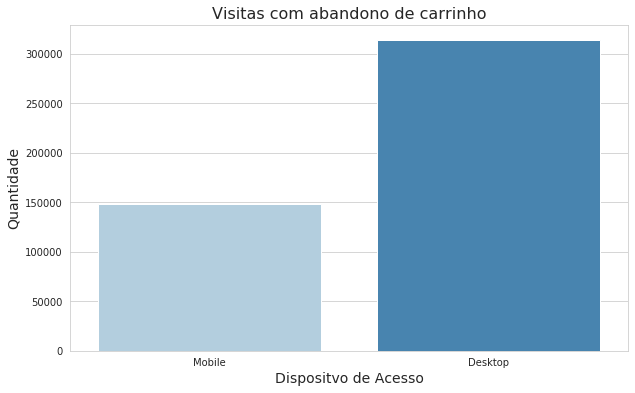

In [74]:
plt.figure(figsize=(10,6))
ax1 = sns.countplot(x='deviceType',data=cart_devices, palette='Blues')
ax1.set_xlabel('Dispositvo de Acesso', fontsize=14)
ax1.set_ylabel('Quantidade', fontsize=14)
ax1.set_xticklabels(['Mobile','Desktop'])
ax1.set_title('Visitas com abandono de carrinho', fontsize=16)
plt.savefig('./Images/Online/Cart-Abandonment-Devices.jpg')

In [75]:
df.groupby('deviceType').count().show()

+----------+-------+
|deviceType|  count|
+----------+-------+
|   desktop|1353749|
|    mobile|2098791|
+----------+-------+



**Número de abandono de carrinho com produto muito maior quando acessado pelo Desktop, mesmo que a quantidade de acessos por este dispositivo seja inferior**

# 4.2 - Usuários Identificados por dispositivo

In [76]:
df.groupby(['customer_id','deviceType']).count().show(5)

+--------------------+----------+-----+
|         customer_id|deviceType|count|
+--------------------+----------+-----+
|65373663346433333161|   desktop|   18|
|65313437663231313432|    mobile|  145|
|63346131613831343164|    mobile|    4|
|38323266376534643338|   desktop|   18|
|33396231336164346437|   desktop|    9|
+--------------------+----------+-----+
only showing top 5 rows



In [77]:
## Agrupa usuarios identificados e respectivos dispositivos de acesso
id_users_sp = df.groupby(['customer_id','deviceType']).count()

In [78]:
id_users = id_users_sp.select("*").toPandas()

In [79]:
## Verifica nulos
id_users.head().isnull().sum()

customer_id    0
deviceType     0
count          0
dtype: int64

In [80]:
## Numero de usuarios identificados
len(id_users)

6710

In [105]:
id_users.deviceType.value_counts()

mobile     4402
desktop    2308
Name: deviceType, dtype: int64

In [97]:
desktop = 1353749
mobile = 2098791

In [108]:
pctg_desktop = id_users.deviceType.value_counts()[1]*100/desktop
pctg_mobile = id_users.deviceType.value_counts()[0]*100/mobile

print("Percentual de usuarios registrados Desktop:", pctg_desktop)
print('Percentual de Usuários registrados Mobile:', pctg_mobile)

Percentual de usuarios registrados Desktop: 0.17048950728680132
Percentual de Usuários registrados Mobile: 0.20973979781693367


In [81]:
id_users.groupby('deviceType').count().reset_index()['customer_id']

0    2307
1    4401
Name: customer_id, dtype: int64

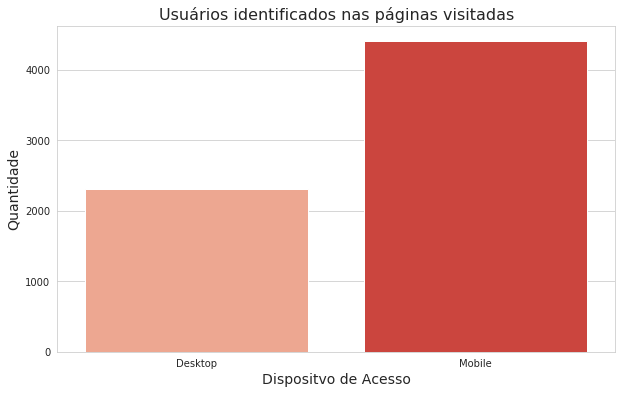

In [82]:
plt.figure(figsize=(10,6))
ax1 = sns.countplot(x='deviceType',data=id_users, palette='Reds')
ax1.set_xlabel('Dispositvo de Acesso', fontsize=14)
ax1.set_ylabel('Quantidade', fontsize=14)
ax1.set_xticklabels(['Desktop','Mobile'])
ax1.set_title('Usuários identificados nas páginas visitadas', fontsize=16)
plt.savefig('./Images/Online/Users-id-count-pageviews.jpg')

**Existem muito mais usuários identificados (o dobro aproximadamente) acessando pelo dispositivo móvel do que pelo desktop**

# 5.0 - Exportar DataFrames

## 5.1 - Criar conjunto de dados

In [83]:
## Importa dataframe auxiliar
df_aux = pd.read_csv('./Outputs/Utils/aux_out_horizontal.csv').drop('Unnamed: 0', axis=1)
df_aux.head()

,faturamento_total,clientes_ambos_identificados,qtd_visualizadores
0,19389777,457,864938


In [84]:
datas = {'faturamento_total':df_aux.faturamento_total.values,
         'clientes_ambos_identificados':df_aux.clientes_ambos_identificados.values,
         'qtd_visualizadores': df_aux.qtd_visualizadores.values,
         'qtd_vist_nao_compradores': [len(no_list)],
         'qtd_id_clientes_n_compradores': [len(clients.customer_id.unique())],
         'produto_mais_vis': ma_product.on_product_id.values,
         'qtd_vis_abandono_carrinho': [len(no_cart_list)],
         'qtd_clientes_abandono_carrinho': [len(clients_cart)],

        } 

In [85]:
## Cria DataFrames de Saída
df_out = pd.DataFrame(datas)
transpose = df_out.transpose()

In [86]:
## Exporta DF de saída para CSV
df_out.to_csv(r'./Outputs/Combined/Combined-Output-Horizontal.csv')
transpose.to_csv(r'./Outputs/Combined/Combined-Output-Vertical.csv')